# Setup

In [5]:
import importlib
import dgl
import torch
import dataloader

In [6]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

subgraph_size=64
num_samples=3200

graph = dataloader.load_DGL("cora")

adj = graph.adj().to_dense().to(device)
feat = graph.ndata['feat'].to(device)
label = graph.ndata['label'].to(device)

train_mask = graph.ndata['train_mask']
test_mask = graph.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# Create samples

<Figure size 432x288 with 0 Axes>

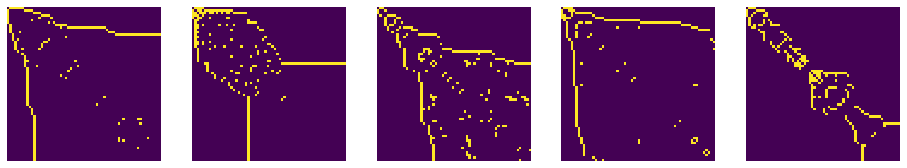

In [7]:
import random
import show_samples

def get_neighbor_subgraphs(adj: torch.Tensor, size: int, n: int) -> torch.Tensor:
    """
    Returns a tensor ~ `(n * size)` of node indices for `n` supgraphs of size `size`
    """
    res = torch.zeros([n, size], dtype=torch.long)

    for i in range(n):
        out = []
        stack = [random.randint(0, adj.shape[0] - 1)]
        while len(out) < size:
            if len(stack) == 0:
                stack.append(random.randint(0, adj.shape[0] - 1))
            curNode = stack.pop()
            if curNode not in out:
                out.append(curNode)
                children = adj[curNode].nonzero().t()[0].cpu().tolist()
                stack = children + stack
        res[i] = torch.tensor(out)

    return res

def get_rand_subgraphs(size: int, n: int) -> torch.Tensor:
    return torch.randint(adj.shape[0], [n, size], dtype=torch.long)

# subgraphs = get_rand_subgraphs(subgraph_size, num_samples).to(device)
subgraphs = get_neighbor_subgraphs(adj.cpu(), subgraph_size, num_samples).to(device)
samples = [adj[subgraphs[i]][:, subgraphs[i]].cpu() for i in range(5)]
show_samples.show_adj(samples)

# Examine clean samples

In [8]:
from torch_geometric.nn import Sequential, DenseGCNConv
from torch.nn import Linear, ReLU
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

def get_gcn(hid: int=64):
    return Sequential('x, adj', [
        (DenseGCNConv(feat.shape[1], hid), 'x, adj -> x'),
        ReLU(inplace=True),
        (DenseGCNConv(hid, hid), 'x, adj -> x'),
        ReLU(inplace=True),
        Linear(hid, int(label.max()) + 1),
    ]).to(device)

def train(model, dataloader: DataLoader, epochs: int):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    t = tqdm(range(epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    t.set_description("Model training")
    loss = torch.tensor(0)
    for _ in t:
        for feats, adjs, labels, train_masks in dataloader:
            pred = model(feats, adjs)
            mask = train_masks.flatten()
            loss = F.cross_entropy(pred.flatten(end_dim=1)[mask], labels.flatten(end_dim=1)[mask])
            loss.backward()
            optimizer.step()
            t.set_postfix({"loss": round(loss.item(), 2)})

def train_adj(model, feat, adj, label, train_mask, epochs: int):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    t = tqdm(range(epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    t.set_description("Model training")
    loss = torch.tensor(0)
    for _ in t:
        pred = model(feat, adj)
        loss = F.cross_entropy(pred.squeeze()[train_mask], label[train_mask])
        loss.backward()
        optimizer.step()
        t.set_postfix({"loss": round(loss.item(), 2)})

def eval(model, test_mask, text=""):
    model.eval()
    pred = model(feat, adj)
    acc = ((pred.argmax(dim=2).squeeze() == label)[test_mask].sum() / test_mask.sum()).item()
    print(text + f"Accuracy: {acc: 0.2%}")

In [10]:
temp = adj[subgraphs]
subgraph_feats = feat[subgraphs]
subgraph_adjs = torch.zeros(num_samples, subgraph_size, subgraph_size).to(device)
subgraph_labels = label[subgraphs]
subgraph_train_masks = train_mask[subgraphs]
for i in range(num_samples):
    subgraph_adjs[i] = temp[i][:,subgraphs[i]]

clean_dataloader = DataLoader(
    TensorDataset(subgraph_feats, subgraph_adjs, subgraph_labels, subgraph_train_masks), 
    batch_size=256, shuffle=True)

gcn = get_gcn()
train(gcn, clean_dataloader, 100)
eval(gcn, test_mask)

Model training: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s, loss=0]  


Accuracy:  62.00%


# Examine noisy samples

<Figure size 432x288 with 0 Axes>

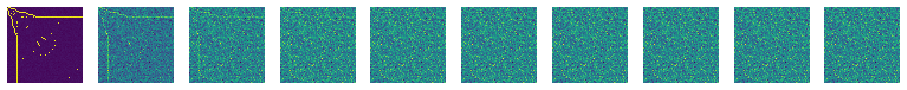

<Figure size 432x288 with 0 Axes>

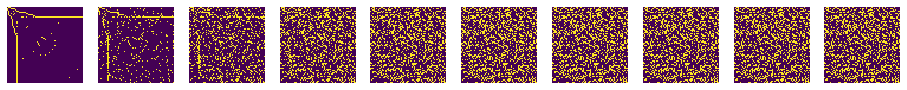

In [ ]:
from model import CondUNet
importlib.reload(CondUNet)

noise_steps = 1000
diff = CondUNet.Diffusion(
    noise_steps=noise_steps,
    device=device,
    img_size=subgraph_size
)

noisy_subgraph_adjs_2d = diff.noise_images(subgraph_adjs.unsqueeze(dim=3), torch.tensor([[x for x in range(0, noise_steps, 100)]]).t())[0]

# subgraphs = get_neighbor_subgraphs(adj.cpu(), subgraph_size, num_samples).to(device)
noisy_samples = [(k[0]).cpu() for k in noisy_subgraph_adjs_2d]
show_samples.show_adj(noisy_samples)
discrete_noisy_samples = [(k[0] > 0.5).cpu() for k in noisy_subgraph_adjs_2d]
show_samples.show_adj(discrete_noisy_samples)


In [ ]:
noisy_subgraph_adjs = (noisy_subgraph_adjs_2d[-1] > 0.5)
noisy_dataloader = DataLoader(
    TensorDataset(subgraph_feats, noisy_subgraph_adjs.squeeze(), subgraph_labels, subgraph_train_masks), 
    batch_size=256, shuffle=True)
gcn = get_gcn()
train(gcn, noisy_dataloader, 100)
eval(gcn, test_mask, "Noisy graphs")

Model training: 100%|██████████| 100/100 [00:08<00:00, 12.43it/s, loss=1.36]


Noisy graphsAccuracy:  55.80%


In [ ]:
from model import Unet
importlib.reload(Unet)

unet = Unet.Unet(
    dim=subgraph_size,
    channels=1,
    dim_mults=(1, 2, 4, 4)
).to(device)

scheduler = Unet.get_scheduler("linear")

Unet.trainUnet(
    model=unet,
    epochs=10,
    adjs=subgraph_adjs.unsqueeze(dim=1) * 2 - 1,
    batch_size=100,
    device=device,
    timesteps=noise_steps,
    scheduler=scheduler
)

Epoch: 0


Batch: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s, loss=1.35] 


Epoch: 1


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s, loss=5.59]


Epoch: 2


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, loss=0.593]


Epoch: 3


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, loss=0.434]


Epoch: 4


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, loss=0.427]


Epoch: 5


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, loss=0.424]


Epoch: 6


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, loss=0.425]


Epoch: 7


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.25it/s, loss=0.424]


Epoch: 8


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s, loss=0.424]


Epoch: 9


Batch: 100%|██████████| 32/32 [00:06<00:00,  5.20it/s, loss=0.423]


In [ ]:
rand_noise = torch.randn((256, 1, subgraph_size, subgraph_size))

generated_samples = Unet.sample_from(
    unet, 
    image_size=subgraph_size, 
    initial_images=rand_noise.to(device), 
    channels=1, 
    scheduler=scheduler, 
    timesteps=noise_steps,
    num_steps=noise_steps
)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 168.00 MiB (GPU 2; 79.21 GiB total capacity; 40.26 GiB already allocated; 14.62 MiB free; 40.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
(generated_samples[0].shape)

(10, 1, 64, 64)

<Figure size 432x288 with 0 Axes>

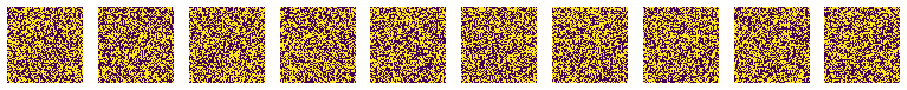

In [ ]:
show_samples.show_adj(generated_samples[-1].squeeze() > 0.5)

# Examine PGD Attack

In [11]:
surrogate = get_gcn()

surrogate.train()
optimizer = torch.optim.Adam(surrogate.parameters(), 1e-3)
t = tqdm(range(500), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
t.set_description("Attacking")
loss = torch.tensor(0)

P = adj.clone()
A_tilde = torch.bernoulli(P)
A_tilde.requires_grad_(True)
for _ in t:
    pred = surrogate(feat, A_tilde)
    loss = F.cross_entropy(pred.squeeze(), label)

    grad = torch.autograd.grad(loss, A_tilde, retain_graph=True)
    # scale = 100000 / (grad[0].abs().sum() + 1)
    P = (P + grad[0]).clamp(0,1)
    A_tilde = torch.bernoulli(P)
    A_tilde.requires_grad_(True)

    loss.backward()
    optimizer.step()
    t.set_postfix({"model loss": round(loss.item(), 2)})

attacked_adj = torch.bernoulli(P)

temp = attacked_adj[subgraphs]
subgraph_adjs_pgd = torch.zeros(num_samples, subgraph_size, subgraph_size).to(device)
for i in range(num_samples):
    subgraph_adjs_pgd[i] = temp[i][:,subgraphs[i]]

Attacking: 100%|██████████| 500/500 [00:03<00:00, 150.75it/s, model loss=1.86]


In [12]:
gcn2 = get_gcn()
train_adj(gcn2, feat, attacked_adj, label, train_mask, 3000)
eval(gcn2, test_mask, "GCN trained on attacked graph ")

gcn3 = get_gcn()
pgd_dataloader = DataLoader(
    TensorDataset(subgraph_feats, subgraph_adjs_pgd, subgraph_labels, subgraph_train_masks),
    batch_size=256, shuffle=True)
train(gcn3, pgd_dataloader, 100)
eval(gcn3, test_mask, "GCN trained on samples of attacked graph ")

Model training: 100%|██████████| 3000/3000 [00:08<00:00, 353.57it/s, loss=0.11]


GCN trained on attacked graph Accuracy:  28.30%


Model training: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s, loss=0.08]


GCN trained on samples of attacked graph Accuracy:  75.50%


# Train diffusion on clean samples

In [ ]:
from model import Unet
importlib.reload(Unet)
timesteps = 400

unet = Unet.Unet(
    dim=subgraph_size,
    channels=1,
    dim_mults=(1, 2, 4, 8)
).to(device)

scheduler = Unet.get_scheduler("linear")

Unet.trainUnet(
    model=unet,
    epochs=3,
    adjs=(adjs * 2) - 1,
    batch_size=64,
    device=device,
    timesteps=timesteps,
    scheduler=scheduler
)

NameError: name 'adjs' is not defined

In [ ]:
rand_noise = torch.randn((10, 1, subgraph_size, subgraph_size))

generated_samples = Unet.sample_from(
    unet, 
    image_size=subgraph_size, 
    initial_images=rand_noise.to(device), 
    channels=1, 
    scheduler=scheduler, 
    timesteps=timesteps,
    num_steps=timesteps
)

sampling loop time step: 100%|██████████| 400/400 [00:06<00:00, 62.70it/s]


<Figure size 432x288 with 0 Axes>

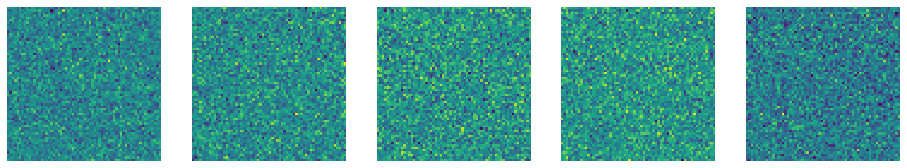

<Figure size 432x288 with 0 Axes>

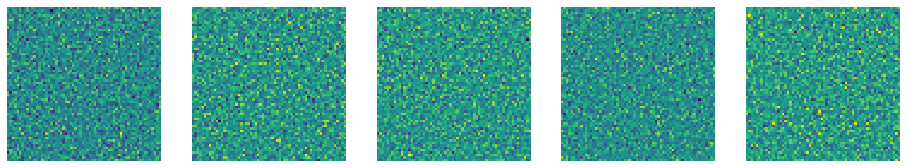

<Figure size 432x288 with 0 Axes>

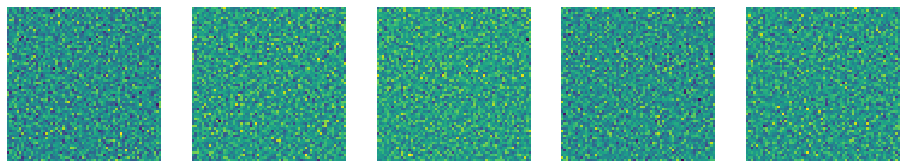

In [ ]:
show_samples.show_adj(generated_samples[0].squeeze()[0:5])
show_samples.show_adj(generated_samples[100].squeeze()[0:5])
show_samples.show_adj(generated_samples[200].squeeze()[0:5])